# Sample Canon Analysis

## Select Image & Phantom and Parse

In [1]:
from pyquantus.parse.canon import canonIqParser, findPreset

In [2]:
# Inputs
imagePath = "/Volumes/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/001/Preset_2/20220427104128_IQ.bin"
phantomPath = "/Volumes/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/20220831121752_IQ.bin"

In [3]:
imPreset = findPreset(imagePath)
phantomPreset = findPreset(phantomPath)
assert imPreset == phantomPreset

In [4]:
imgDataStruct, imgInfoStruct, refDataStruct, refInfoStuct = canonIqParser(imagePath, phantomPath)

/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/pyquantus/parse/canon.py:77: RuntimeWarning: divide by zero encountered in log10
  bmode = 20*np.log10(abs(iq))


## ROI Selection (from GUI)

In [5]:
import pickle

pkl_name = "/Volumes/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/001/ROIs/20220427104128_IQ/high.pkl"

with open(pkl_name, "rb") as f:
    roi_info = pickle.load(f)

In [7]:
from pathlib import Path

assert roi_info["Image Name"] == Path(imagePath).name
assert roi_info["Phantom Name"] == Path(phantomPath).name

In [8]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]

## Analysis Config (from GUI)

In [9]:
from pyquantus.qus import AnalysisConfig

pkl_name = Path("/Volumes/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/analysisConfig.pkl")

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [12]:
config = config_info["Config"]

## Spectral Analysis

In [13]:
from pyquantus.qus import SpectralAnalysis, UltrasoundImage

In [14]:
ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.scBmodeStruct.preScArr
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [15]:
spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [16]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

In [17]:
print(spectralAnalysis.attenuationCoef, spectralAnalysis.attenuationCorr)

-0.2584613471655339 0.2705476717291134


In [18]:
spectralAnalysis.backScatterCoef

0.007642667494852243

In [19]:
spectralAnalysis.nakagamiParams

(2.4660738650904923, 0.23911688258376726)

In [20]:
print(spectralAnalysis.effectiveScattererDiameter, spectralAnalysis.effectiveScattererConcentration)

1.4321887874843727e-07 72496673220532.78


# Visualizations

In [21]:
import matplotlib.pyplot as plt

from pyquantus.qus import SpectralData
from pyquantus.parse.objects import ScConfig

In [22]:
scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

In [23]:
spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [24]:
spectralData.convertImagesToRGB()

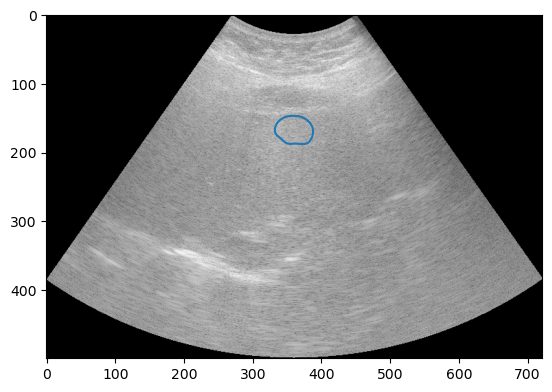

In [25]:
plt.imshow(spectralData.scBmode)
plt.plot(scSplineX, scSplineY)

In [26]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

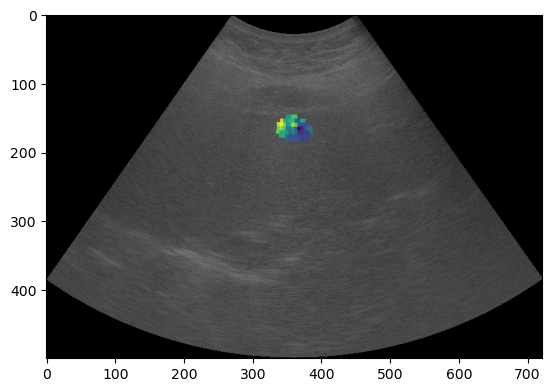

In [27]:
plt.imshow(spectralData.scMbfIm)

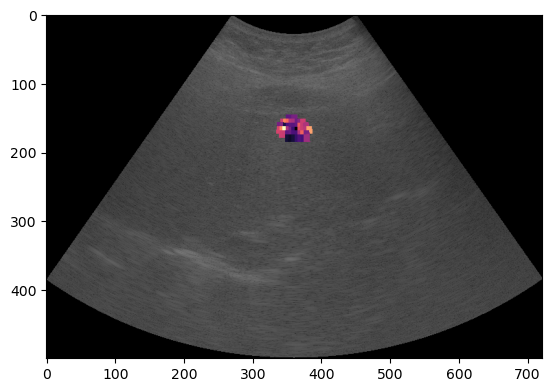

In [28]:
plt.imshow(spectralData.scSsIm)

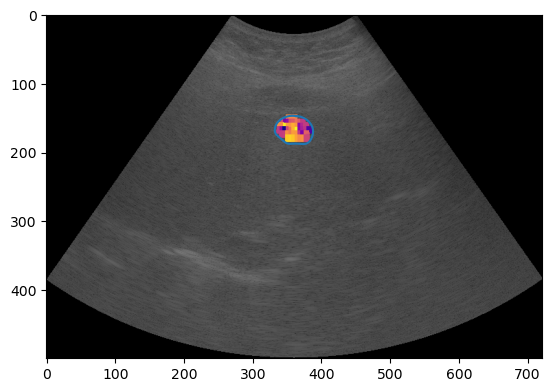

In [29]:
plt.imshow(spectralData.scSiIm)
plt.plot(spectralData.splineX, spectralData.splineY)

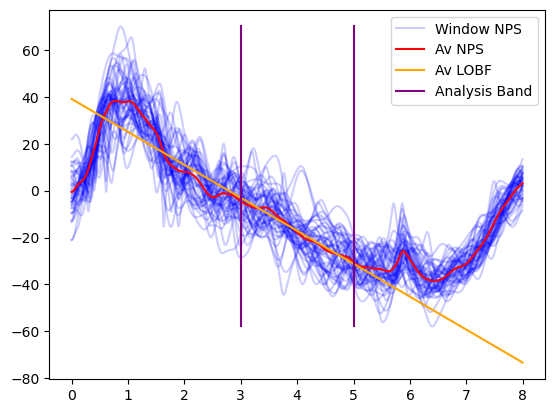

In [30]:
spectralData.plotPsData()